In [2]:
#note: environment needs allensdk installed (works in python 3.8, allensdk 2.13.5)

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection

import os
from pathlib import Path
from allensdk.core.reference_space_cache import ReferenceSpaceCache

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#load CCF

#set this to the directory where you want the CCF to be downloaded
output_dir=r"D:\CCF\cache"
reference_space_key = 'annotation/ccf_2022'
resolution = 10
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=Path(output_dir) / 'manifest.json')
# get structure tree
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 
#get id_acronym map
id_acronym_map = tree.get_id_acronym_map()
#make reference space object
rsp = rspc.get_reference_space()
#get annotation volume
annotation, meta = rspc.get_annotation_volume()

In [6]:
#load single cell metric data
all_data_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\new_annotations\single unit metrics\combined\all_data_plus_performance.pkl"
all_data=pd.read_pickle(all_data_path)

In [7]:
all_data.columns.values

array(['amplitude_cutoff', 'amplitude_cv_median', 'amplitude_cv_range',
       'amplitude_median', 'drift_ptp', 'drift_std', 'drift_mad',
       'firing_range', 'firing_rate', 'isi_violations_ratio',
       'isi_violations_count', 'num_spikes', 'presence_ratio',
       'rp_contamination', 'rp_violations', 'sliding_rp_violation', 'snr',
       'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'd_prime',
       'isolation_distance', 'l_ratio', 'silhouette', 'nn_hit_rate',
       'nn_miss_rate', 'exp_decay', 'half_width', 'num_negative_peaks',
       'num_positive_peaks', 'peak_to_valley', 'peak_trough_ratio',
       'recovery_slope', 'repolarization_slope', 'spread',
       'velocity_above', 'velocity_below', 'electrode_group_name',
       'peak_channel', 'cluster_id', 'default_qc', 'amplitude',
       'channels', 'unit_id', 'group_name', 'ccf_ap', 'ccf_dv', 'ccf_ml',
       'structure', 'location', 'peak_electrode', 'obs_intervals',
       'electrodes', 'device_name', 'session_idx', 'date

In [8]:
#correct pvals for multiple comparisons

sel_project='DynamicRouting'
sel_units=all_data.query('presence_ratio>=0.99 and \
                            isi_violations_ratio<=0.1 and \
                            amplitude_cutoff<=0.1 and \
                            project.str.contains(@sel_project) and \
                            ~structure.isna() and ~location.isna() and \
                            n_good_blocks>=4')

adj_pvals=pd.DataFrame({
    'unit_id':sel_units['unit_id'].values,
    'session_id':sel_units['session_id'].values,
    'structure':sel_units['structure'].values,
    'location':sel_units['location'].values,
    'peak_to_valley':sel_units['peak_to_valley'].values,
    'vis1':fdrcorrection(sel_units['vis1_stimulus_modulation_p_value'])[1],
    'vis2':fdrcorrection(sel_units['vis2_stimulus_modulation_p_value'])[1],
    'sound1':fdrcorrection(sel_units['sound1_stimulus_modulation_p_value'])[1],
    'sound2':fdrcorrection(sel_units['sound2_stimulus_modulation_p_value'])[1],
    'catch':fdrcorrection(sel_units['catch_stimulus_modulation_p_value'])[1],
    'vis1_late':fdrcorrection(sel_units['vis1_stimulus_late_modulation_p_value'])[1],
    'vis2_late':fdrcorrection(sel_units['vis2_stimulus_late_modulation_p_value'])[1],
    'sound1_late':fdrcorrection(sel_units['sound1_stimulus_late_modulation_p_value'])[1],
    'sound2_late':fdrcorrection(sel_units['sound2_stimulus_late_modulation_p_value'])[1],
    'catch_late':fdrcorrection(sel_units['catch_stimulus_late_modulation_p_value'])[1],
    'context':fdrcorrection(sel_units['baseline_context_modulation_p_value'])[1],
    'context_linear_shift':sel_units[['linear_shift_baseline_context_p_value_higher',
                                    'linear_shift_baseline_context_p_value_lower']].min(axis=1),
    'context_linear_shift_diff_from_null':((sel_units['linear_shift_baseline_context_true_value']-
                                        sel_units['linear_shift_baseline_context_null_median'])/
                                            sel_units['linear_shift_baseline_context_null_std']),

    'vis1_latency':sel_units['vis1_stim_latency'],
    'vis2_latency':sel_units['vis2_stim_latency'],
    'sound1_latency':sel_units['sound1_stim_latency'],
    'sound2_latency':sel_units['sound2_stim_latency'],
    'catch_latency':sel_units['catch_stim_latency'],

    'vis1_roc_auc':sel_units['vis1_stimulus_modulation_roc_auc'],
    'vis2_roc_auc':sel_units['vis2_stimulus_modulation_roc_auc'],
    'sound1_roc_auc':sel_units['sound1_stimulus_modulation_roc_auc'],
    'sound2_roc_auc':sel_units['sound2_stimulus_modulation_roc_auc'],
    'context_roc_auc':sel_units['baseline_context_roc_auc'],

    # 'lick_vis':fdrcorrection(sel_units['vis_lick_modulation_p_value'])[1],
    # 'lick_aud':fdrcorrection(sel_units['aud_lick_modulation_p_value'])[1],
    'lick':fdrcorrection(sel_units['lick_modulation_p_value'])[1],
    'lick_roc_auc':sel_units['lick_modulation_roc_auc'],

    'context_sign':sel_units['baseline_context_modulation_sign'],

    'vis1_context':fdrcorrection(sel_units['vis1_context_modulation_p_value'])[1],
    'vis2_context':fdrcorrection(sel_units['vis2_context_modulation_p_value'])[1],
    'sound1_context':fdrcorrection(sel_units['sound1_context_modulation_p_value'])[1],
    'sound2_context':fdrcorrection(sel_units['sound2_context_modulation_p_value'])[1],
    'catch_context':fdrcorrection(sel_units['catch_context_modulation_p_value'])[1],

    'vis1_context_roc_auc':sel_units['vis1_context_modulation_roc_auc'],
    'vis2_context_roc_auc':sel_units['vis2_context_modulation_roc_auc'],
    'sound1_context_roc_auc':sel_units['sound1_context_modulation_roc_auc'],
    'sound2_context_roc_auc':sel_units['sound2_context_modulation_roc_auc'],
    'catch_context_roc_auc':sel_units['catch_context_modulation_roc_auc'],

    # 'vis1_context_sign':sel_units['vis1_context_modulation_zscore'],
    # 'vis2_context_sign':sel_units['vis2_context_modulation_zscore'],
    # 'sound1_context_sign':sel_units['sound1_context_modulation_zscore'],
    # 'sound2_context_sign':sel_units['sound2_context_modulation_zscore'],
    'vis1_context_sign':sel_units['vis1_context_modulation_sign'],
    'vis2_context_sign':sel_units['vis2_context_modulation_sign'],
    'sound1_context_sign':sel_units['sound1_context_modulation_sign'],
    'sound2_context_sign':sel_units['sound2_context_modulation_sign'],

    'vis1_context_evoked':fdrcorrection(sel_units['vis1_evoked_context_modulation_p_value'])[1],
    'vis2_context_evoked':fdrcorrection(sel_units['vis2_evoked_context_modulation_p_value'])[1],
    'sound1_context_evoked':fdrcorrection(sel_units['sound1_evoked_context_modulation_p_value'])[1],
    'sound2_context_evoked':fdrcorrection(sel_units['sound2_evoked_context_modulation_p_value'])[1],
    'catch_context_evoked':fdrcorrection(sel_units['catch_evoked_context_modulation_p_value'])[1],

    'ccf_ap':sel_units['ccf_ap'],
    'ccf_dv':sel_units['ccf_dv'],
    'ccf_ml':sel_units['ccf_ml'],
})

if 'Templeton' in sel_project:
    adj_pvals['lick']=np.ones(len(adj_pvals))

adj_pvals['any_stim']=adj_pvals[['vis1','vis2','sound1','sound2']].min(axis=1)

### plot unit metrics in selected areas - point for each unit

In [10]:
#make structure mask and collect decoder accuracy for these areas

# structure_list=['MOs','MOp','SS','ORB','FRP','ACA','ILA','PL','AI','GU','RSP','VIS','AUD','PTLp','TEa','PERI','ECT','VISC']
structure_list=['MOs']
# structure_list=['RT']
# structure_list=['CP']
dprime_threshold=1.0

#use allensdk to get 3-d structure mask from selected areas
structure_id_list=[id_acronym_map[structure_list[0]]]
if len(structure_list)>1:
    for sel_area in structure_list[1:]:
        structure_id_list.append(id_acronym_map[sel_area])
area_mask=rsp.make_structure_mask(structure_id_list)

structure_list_join="|".join(structure_list)

#select units in these areas
area_units=sel_units.query('structure.str.contains(@structure_list_join)')
area_adj_pvals=adj_pvals.query('structure.str.contains(@structure_list_join)')

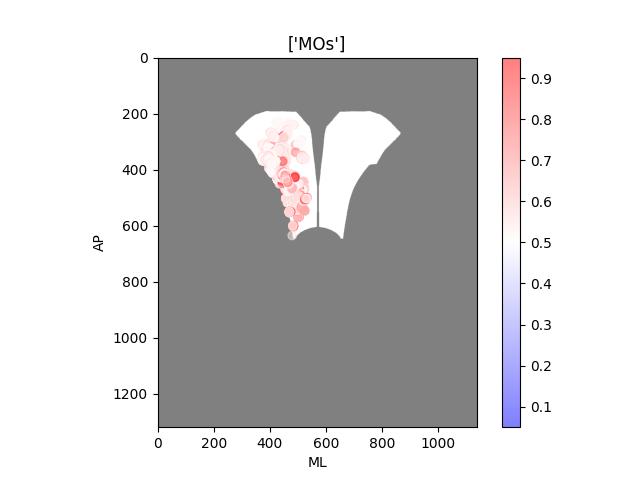

In [11]:
# plot unit metrics

### choose a metric to plot
plot_variable='vis1_roc_auc'
# plot_variable='sound1_roc_auc'
# plot_variable='context_roc_auc'
# plot_variable='lick_roc_auc'

if 'roc_auc' in plot_variable:
    #normalize roc_auc values
    plot_data=np.abs(0.5-area_adj_pvals[plot_variable].to_numpy(dtype=float))+0.5
    maxrange=np.nanmax(plot_data)*0.95
    minrange=1-maxrange
else:
    plot_data=area_adj_pvals[plot_variable].to_numpy(dtype=float)
    minrange=np.nanmin(plot_data)
    maxrange=np.nanmax(plot_data)

#horizontal view
fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=1),cmap='gray',alpha=0.5)
points=ax.scatter(area_units['ccf_ml']/10,area_units['ccf_ap']/10,c=plot_data,alpha=0.5,cmap='bwr',vmin=minrange,vmax=maxrange)
ax.set_xlabel('ML')
ax.set_ylabel('AP')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)


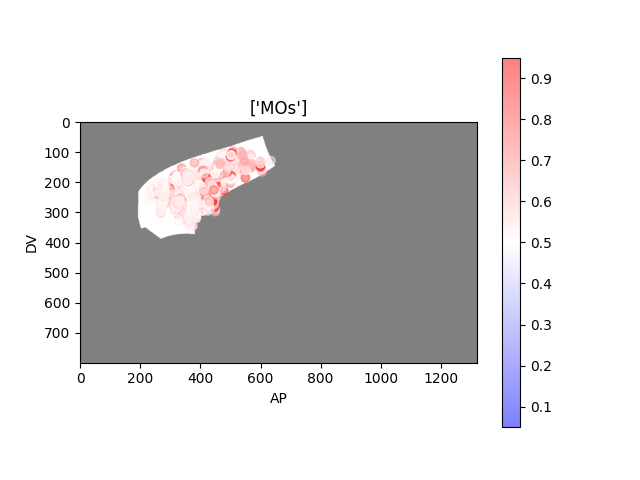

In [12]:
#sagittal view

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=2).T,cmap='gray',alpha=0.5)
points=ax.scatter(area_units['ccf_ap']/10,area_units['ccf_dv']/10,c=plot_data,alpha=0.5,cmap='bwr',vmin=minrange,vmax=maxrange)
ax.set_xlabel('AP')
ax.set_ylabel('DV')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)

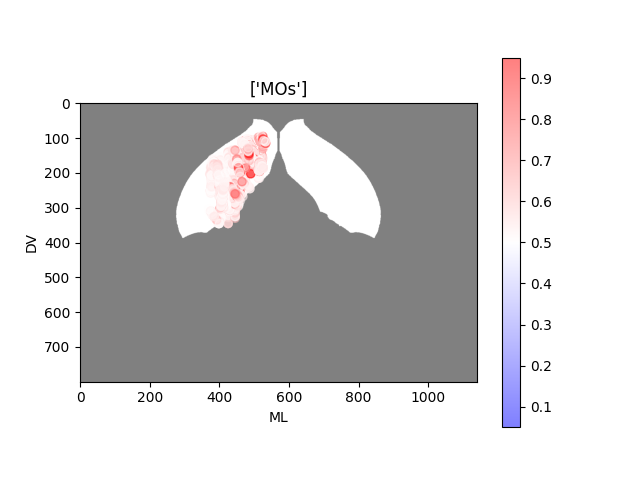

In [13]:
#coronal view

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=0),cmap='gray',alpha=0.5)
points=ax.scatter(area_units['ccf_ml']/10,area_units['ccf_dv']/10,c=plot_data,alpha=0.5,cmap='bwr',vmin=minrange,vmax=maxrange)
ax.set_xlabel('ML')
ax.set_ylabel('DV')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)

## 2-d histogram of unit metrics in selected areas

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_33480\1942883142.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,1)


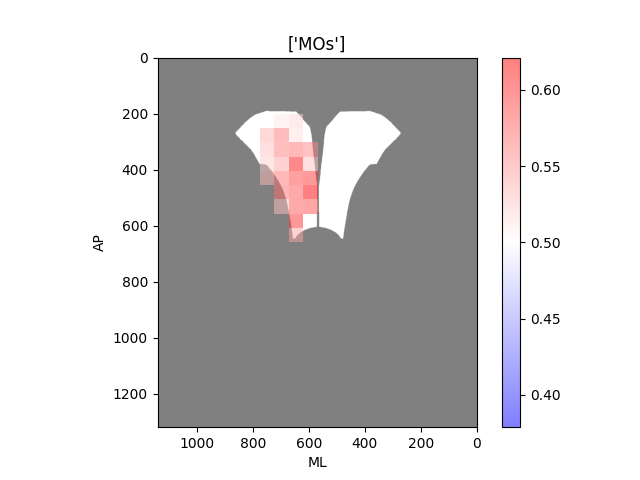

In [14]:
#horizontal view - histogram
#ccf shape = a/p, d/v, m/l

# plot_variable='sound1_roc_auc'
plot_variable='vis1_roc_auc'
# plot_variable='context_roc_auc'
# plot_variable='lick_roc_auc'

if 'roc_auc' in plot_variable:
    #normalize roc_auc values
    plot_data=np.abs(0.5-area_adj_pvals[plot_variable].to_numpy(dtype=float))+0.5
else:
    plot_data=area_adj_pvals[plot_variable].to_numpy(dtype=float)

#size of bins in microns
binsize=50

xsize=annotation.shape[2]
ysize=annotation.shape[0]

xinput=area_units['ccf_ml'].to_numpy(dtype=float)/10
yinput=area_units['ccf_ap'].to_numpy(dtype=float)/10

statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))

if 'roc_auc' in plot_variable:
    maxrange=np.nanmax(statbins.statistic)*0.95
    minrange=1-maxrange
else:
    minrange=np.nanmin(statbins.statistic)
    maxrange=np.nanmax(statbins.statistic)

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=1),cmap='gray',alpha=0.5)
values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='bwr',alpha=0.5,vmin=minrange,vmax=maxrange)
ax.set_aspect('equal')
ax.set_xlabel('ML')
ax.set_ylabel('AP')
ax.set_title(structure_list)
fig.colorbar(ax=ax,mappable=values)

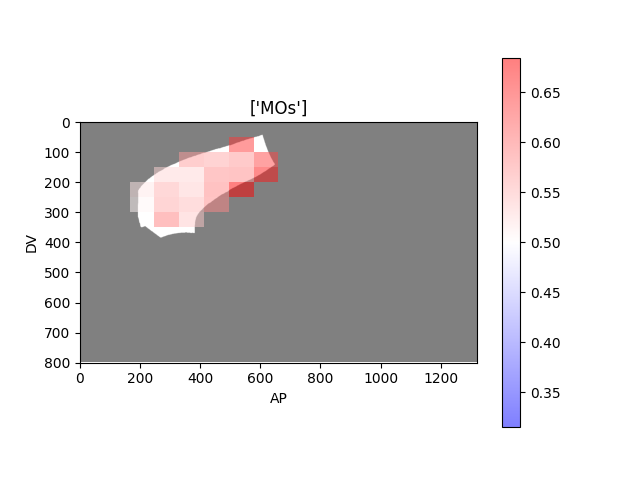

In [15]:
# sagittal view - histogram

xsize=annotation.shape[0]
ysize=annotation.shape[1]

xinput=area_units['ccf_ap'].to_numpy(dtype=float)/10
yinput=area_units['ccf_dv'].to_numpy(dtype=float)/10

statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(ysize/binsize), int(annotation.shape[1]/binsize)), range=((0,xsize), (0,ysize)))

if 'roc_auc' in plot_variable:
    maxrange=np.nanmax(statbins.statistic)*0.95
    minrange=1-maxrange
else:
    minrange=np.nanmin(statbins.statistic)
    maxrange=np.nanmax(statbins.statistic)

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=2).T,cmap='gray',alpha=0.5)
values=ax.imshow(statbins.statistic.T,extent=[0,xsize,ysize,0],cmap='bwr',alpha=0.5,vmin=minrange,vmax=maxrange)
ax.set_aspect('equal')
ax.set_xlabel('AP')
ax.set_ylabel('DV')
ax.set_title(structure_list)
fig.colorbar(ax=ax,mappable=values)

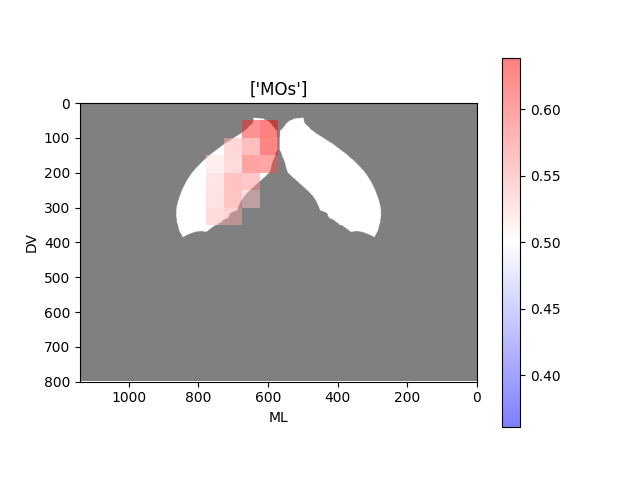

In [16]:
#coronal view - histogram

xsize=annotation.shape[2]
ysize=annotation.shape[1]

xinput=area_units['ccf_ml'].to_numpy(dtype=float)/10
yinput=area_units['ccf_dv'].to_numpy(dtype=float)/10

statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))

if 'roc_auc' in plot_variable:
    maxrange=np.nanmax(statbins.statistic)*0.95
    minrange=1-maxrange
else:
    minrange=np.nanmin(statbins.statistic)
    maxrange=np.nanmax(statbins.statistic)

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=0),cmap='gray',alpha=0.5)
values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='bwr',alpha=0.5,vmin=minrange,vmax=maxrange)
ax.set_aspect('equal')
ax.set_xlabel('ML')
ax.set_ylabel('DV')
ax.set_title(structure_list)
fig.colorbar(ax=ax,mappable=values)


## plot unit metrics histogram on CCF slices - coronal

In [ ]:
#plot histogram on successive coronal slices

# plot slices
dprime_thresh=1.0

binsize=50

slice_size=500
slice_pos_array=np.arange(2000+slice_size/2,10500,slice_size)
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-05-23-single_unit_topography"

# plot_variable='context_roc_auc'
# plot_variable='sound1_roc_auc'
plot_variable='vis1_roc_auc'
# plot_variable='lick_roc_auc'


for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(0, slice_pos)
    results= adj_pvals.query('ccf_ap >= @slice_pos-@slice_size/2 and ccf_ap < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    # ax.imshow(data,cmap='gray',extent=[1140,0,800,0]) 
    ax.imshow(gray_image,extent=[1140,0,800,0],cmap='gray') 

    xsize=annotation.shape[2]
    ysize=annotation.shape[1]

    xinput=results['ccf_ml'].to_numpy(dtype=float)/10
    yinput=results['ccf_dv'].to_numpy(dtype=float)/10

    if 'roc_auc' in plot_variable:
        plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
    else:
        plot_data=results[plot_variable].to_numpy(dtype=float)

    statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='bwr',alpha=0.5,vmin=0.35,vmax=0.65)

    # points=ax.scatter(1140-results['ccf_ml']/10,results['ccf_dv']/10,c=np.abs(results[plot_variable]),alpha=0.5,cmap='Reds')#,vmin=-0.2,vmax=0.2)
    ax.set_xlabel('ML')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=values,label=plot_variable)
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    # filesavepath=os.path.join(savepath,plot_variable+'_coronal_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)


In [ ]:
#plot multiple unit metrics on one figure

# plot slices
dprime_thresh=1.0

binsize=25

slice_size=500
slice_pos_array=np.arange(2000+slice_size/2,10500,slice_size)
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-05-23-single_unit_topography"

plot_variables=['context_roc_auc','lick_roc_auc','sound1_roc_auc','vis1_roc_auc']


for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(0, slice_pos)
    results= adj_pvals.query('ccf_ap >= @slice_pos-@slice_size/2 and ccf_ap < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig,ax = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
    ax=ax.flatten()

    # ax.imshow(data,cmap='gray',extent=[1140,0,800,0]) 
    for pv,plot_variable in enumerate(plot_variables):
        ax[pv].imshow(gray_image,extent=[1140,0,800,0],cmap='gray') 

        xsize=annotation.shape[2]
        ysize=annotation.shape[1]

        xinput=results['ccf_ml'].to_numpy(dtype=float)/10
        yinput=results['ccf_dv'].to_numpy(dtype=float)/10

        if 'roc_auc' in plot_variable:
            plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
        else:
            plot_data=results[plot_variable].to_numpy(dtype=float)

        statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
        if 'context' in plot_variable:
            minval=0.4
            maxval=0.6
        elif 'lick' in plot_variable:
            minval=0.3
            maxval=0.7
        else:
            minval=0.35
            maxval=0.65
        values=ax[pv].imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='bwr',alpha=0.5,vmin=minval,vmax=maxval)

        # points=ax.scatter(1140-results['ccf_ml']/10,results['ccf_dv']/10,c=np.abs(results[plot_variable]),alpha=0.5,cmap='Reds')#,vmin=-0.2,vmax=0.2)
        ax[pv].set_xlabel('ML')
        ax[pv].set_ylabel('DV')
        ax[pv].set_title(plot_variable)
        fig.colorbar(ax=ax[pv],mappable=values,label='roc_auc')

    fig.tight_layout()

    # filesavepath=os.path.join(savepath,'combined','combined_coronal_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)


In [ ]:
#plot fraction affected

#plot multiple unit metrics on one figure

# plot slices
dprime_thresh=1.0
p_thresh=0.05

binsize=25

slice_size=500
slice_pos_array=np.arange(2000+slice_size/2,10500,slice_size)
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-05-23-single_unit_topography"

plot_variables=['context','lick','sound1','vis1']


for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(0, slice_pos)
    results= adj_pvals.query('ccf_ap >= @slice_pos-@slice_size/2 and ccf_ap < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig,ax = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
    ax=ax.flatten()

    # ax.imshow(data,cmap='gray',extent=[1140,0,800,0]) 
    for pv,plot_variable in enumerate(plot_variables):
        ax[pv].imshow(gray_image,extent=[1140,0,800,0],cmap='gray') 

        xsize=annotation.shape[2]
        ysize=annotation.shape[1]

        xinput=results['ccf_ml'].to_numpy(dtype=float)/10
        yinput=results['ccf_dv'].to_numpy(dtype=float)/10

        if 'roc_auc' in plot_variable:
            plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
        else:
            plot_data=(results[plot_variable]<p_thresh).to_numpy(dtype=float)

        statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
        if 'context' in plot_variable:
            minval=0
            maxval=1
        elif 'lick' in plot_variable:
            minval=0
            maxval=1
        else:
            minval=0
            maxval=1
        values=ax[pv].imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='Reds',alpha=0.5,vmin=minval,vmax=maxval)

        # points=ax.scatter(1140-results['ccf_ml']/10,results['ccf_dv']/10,c=np.abs(results[plot_variable]),alpha=0.5,cmap='Reds')#,vmin=-0.2,vmax=0.2)
        ax[pv].set_xlabel('ML')
        ax[pv].set_ylabel('DV')
        ax[pv].set_title(plot_variable)
        fig.colorbar(ax=ax[pv],mappable=values,label='fraction of units')

    fig.tight_layout()

    # filesavepath=os.path.join(savepath,'combined','frac_affected_combined_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)


## metrics on CCF slices - horizontal

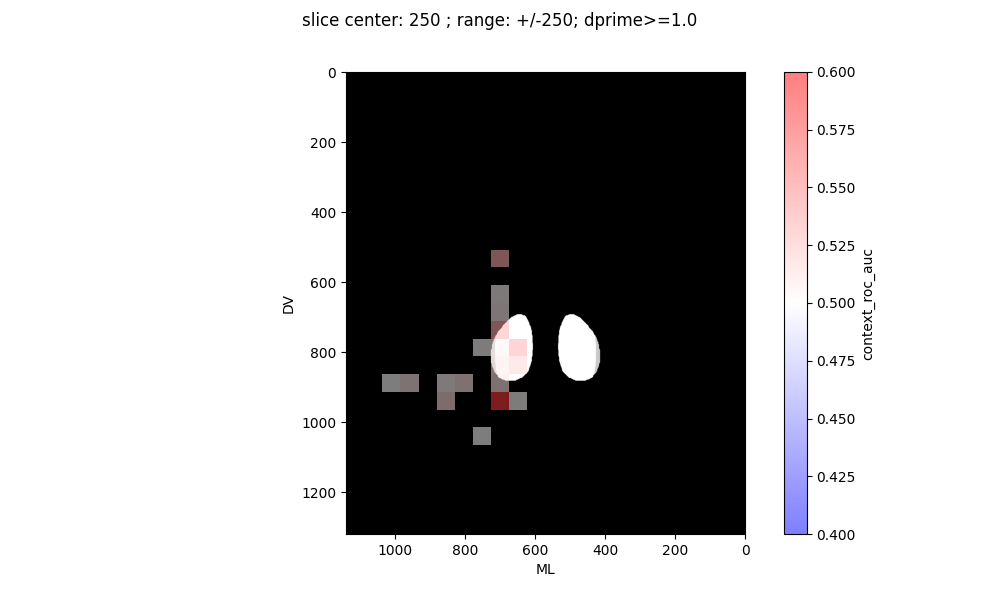

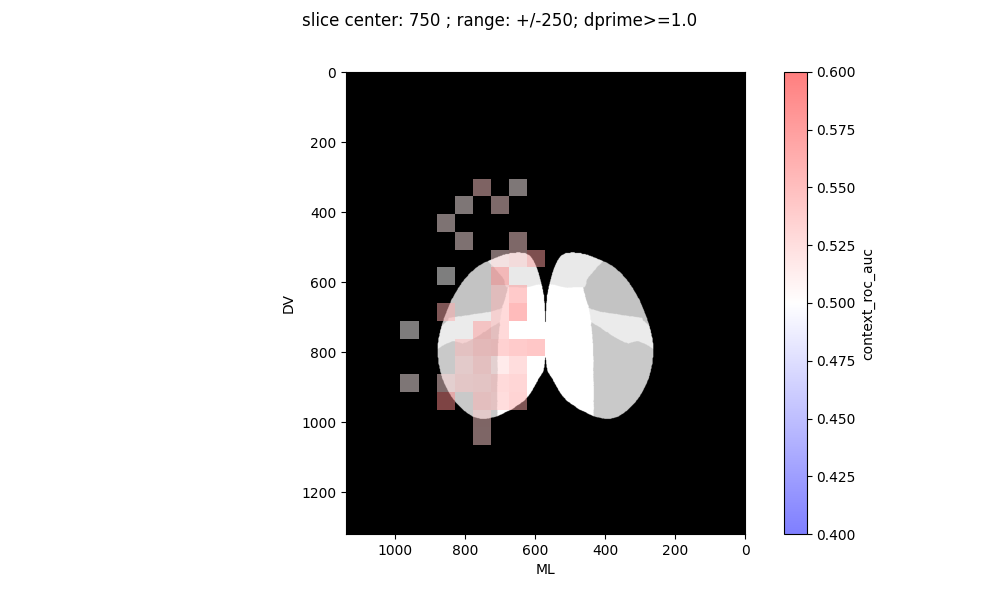

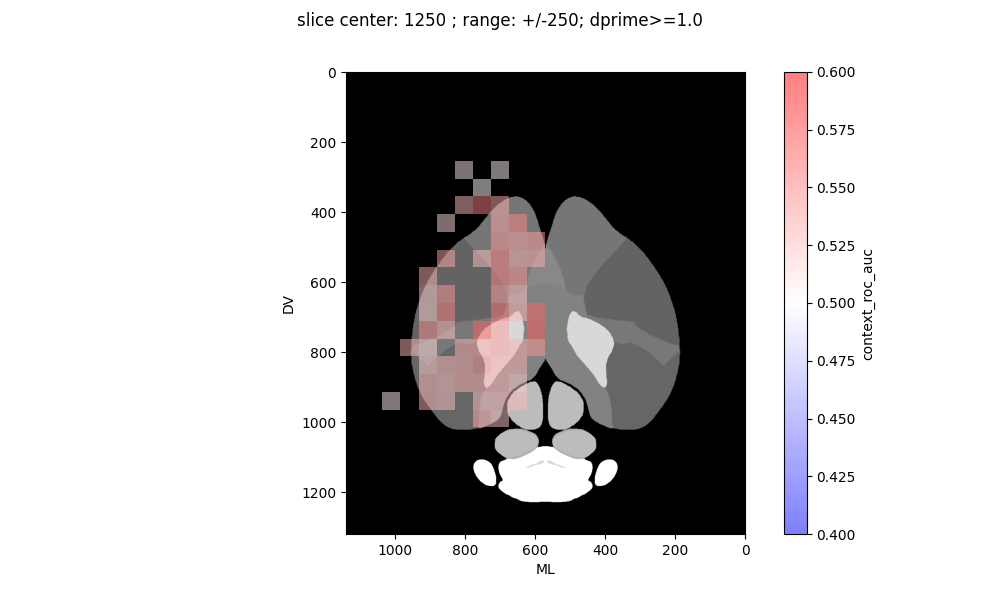

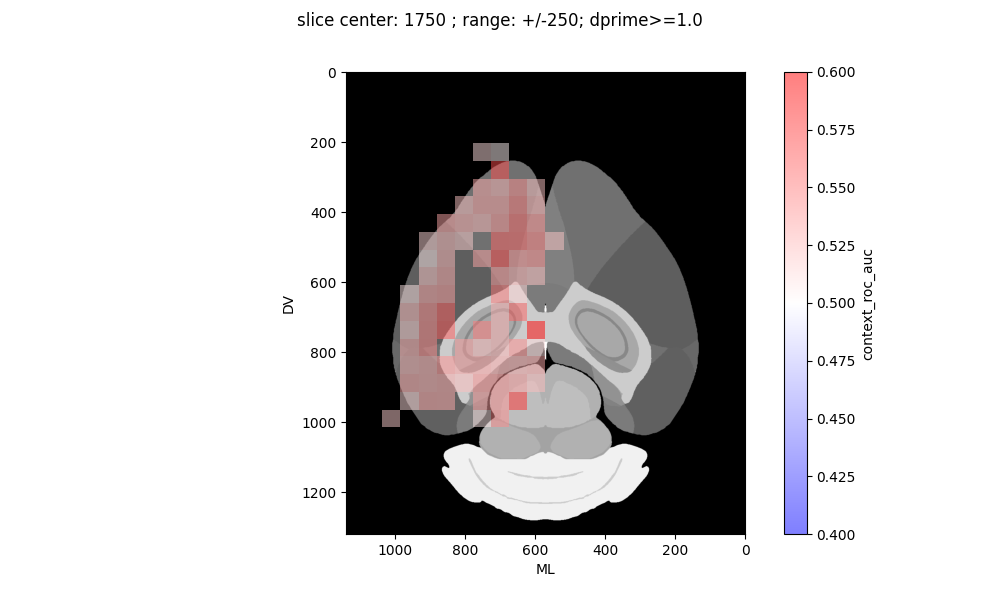

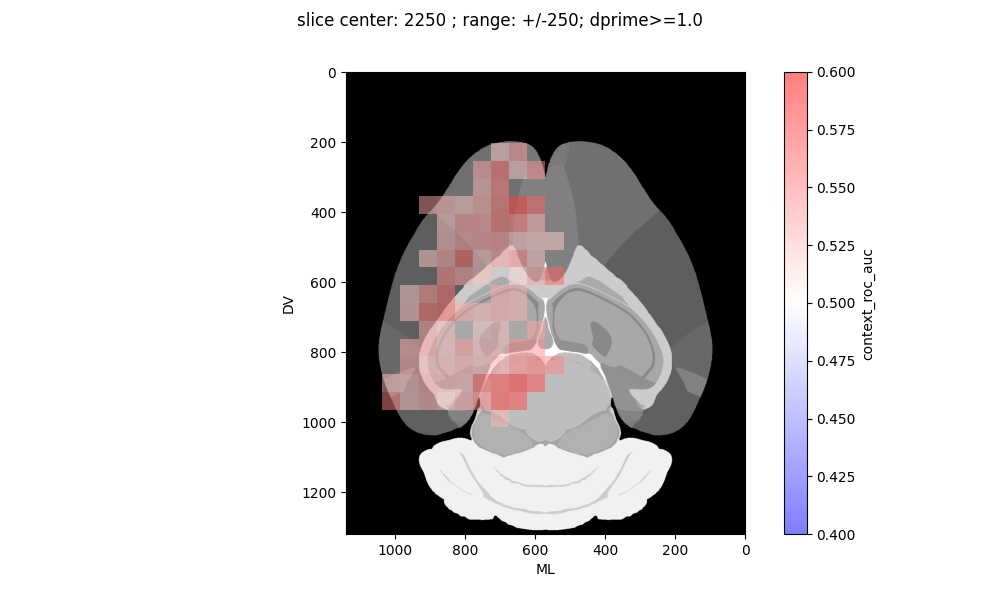

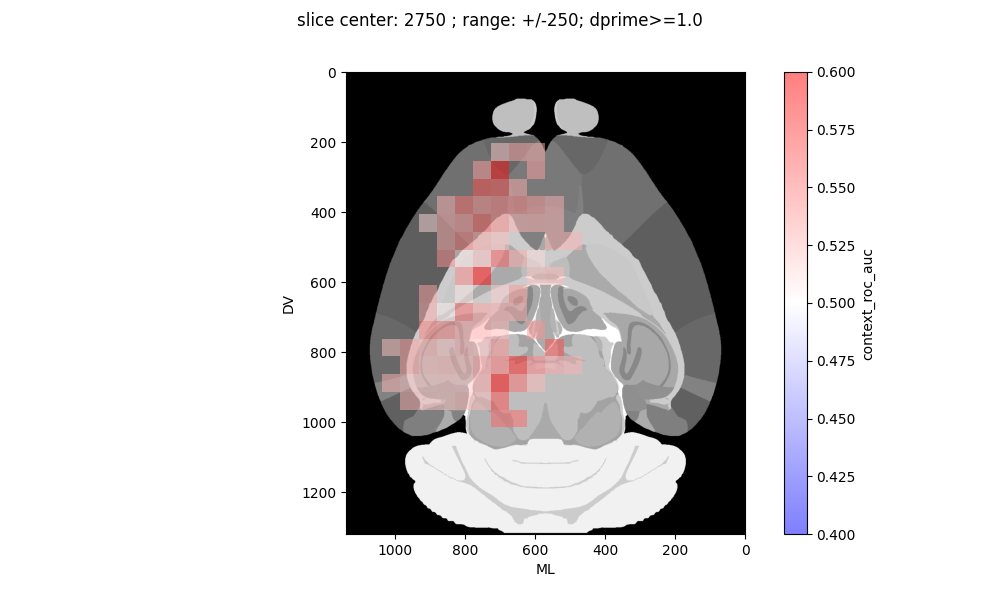

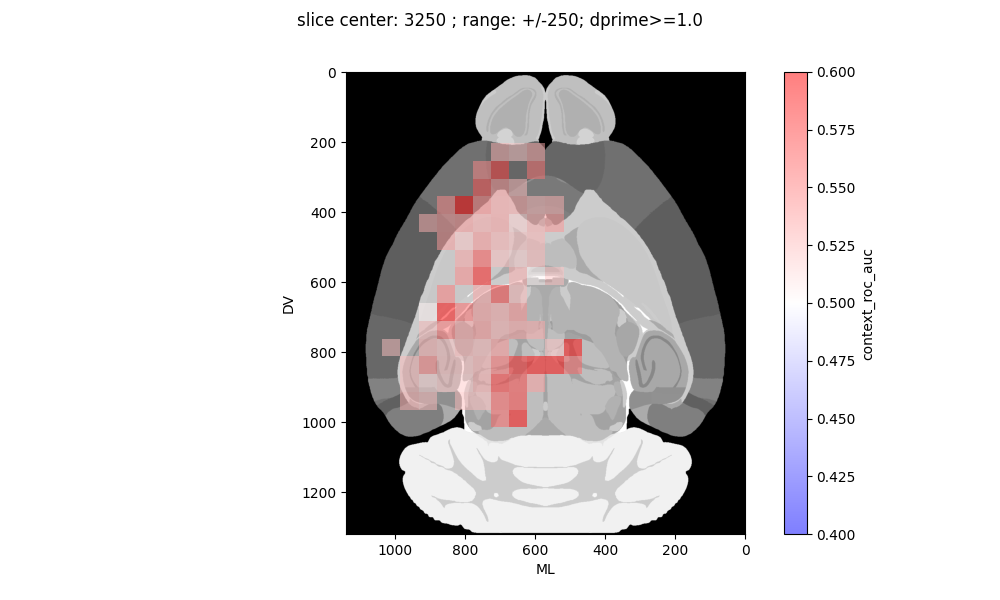

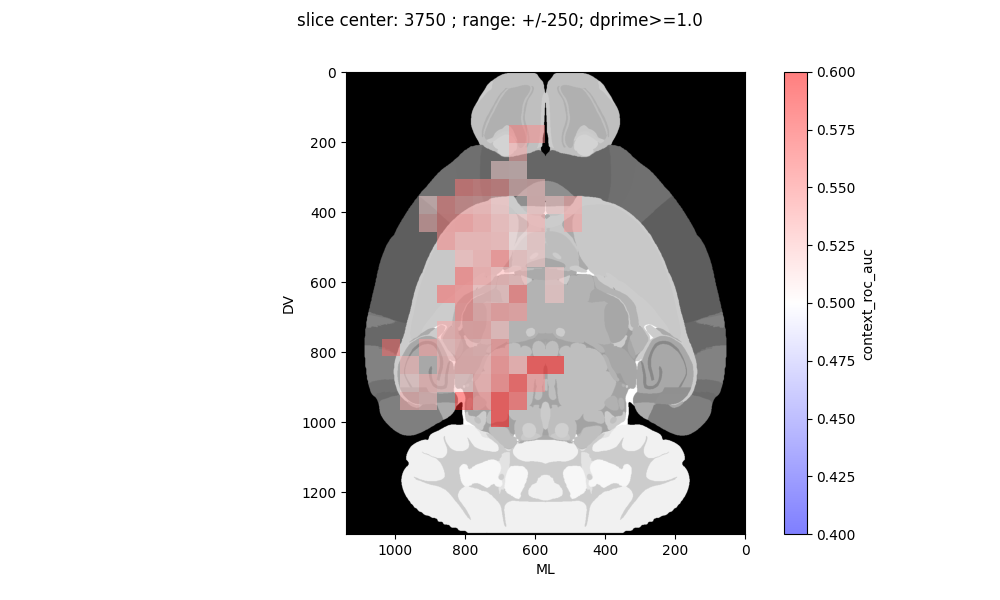

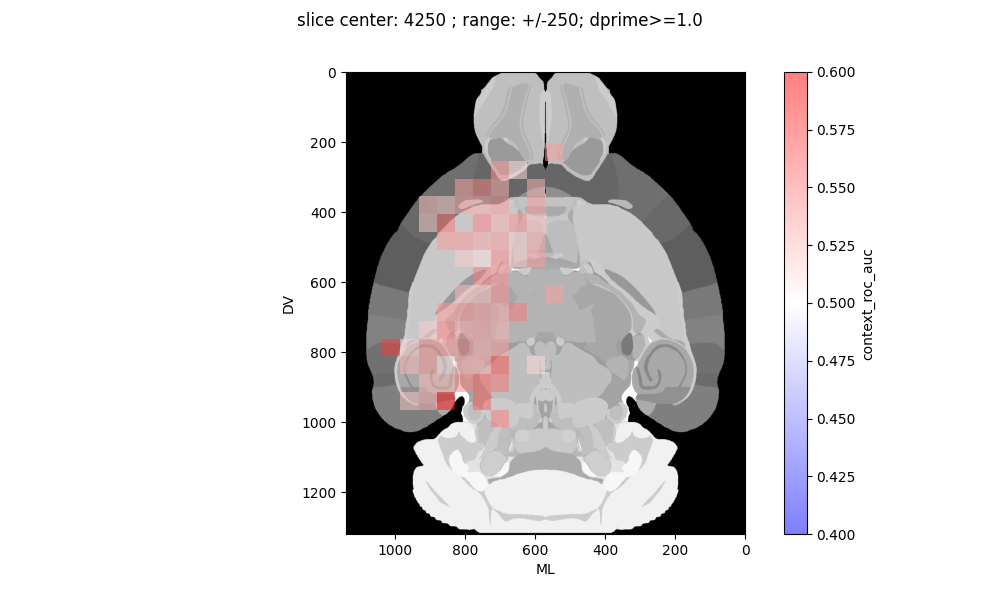

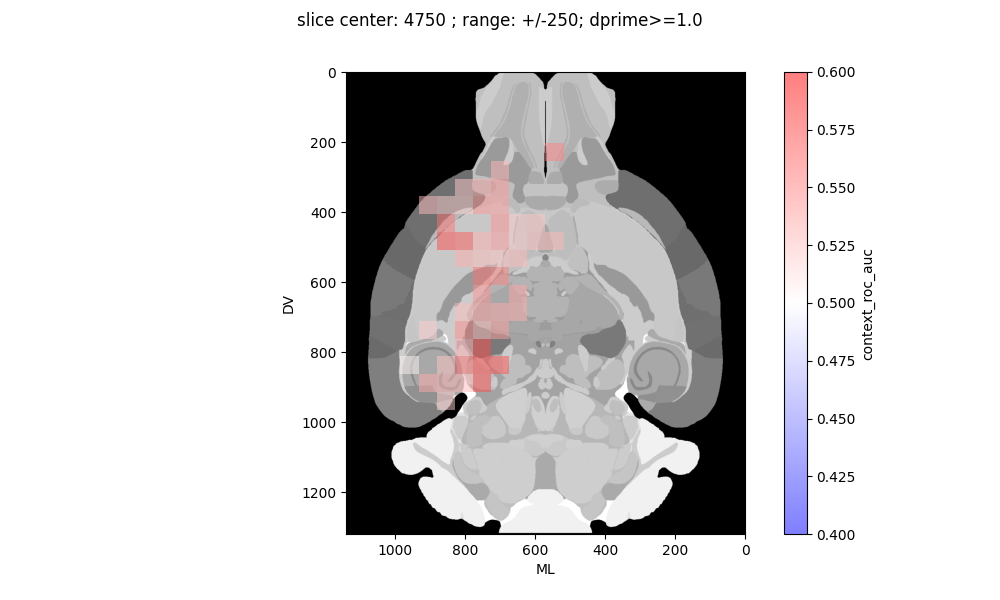

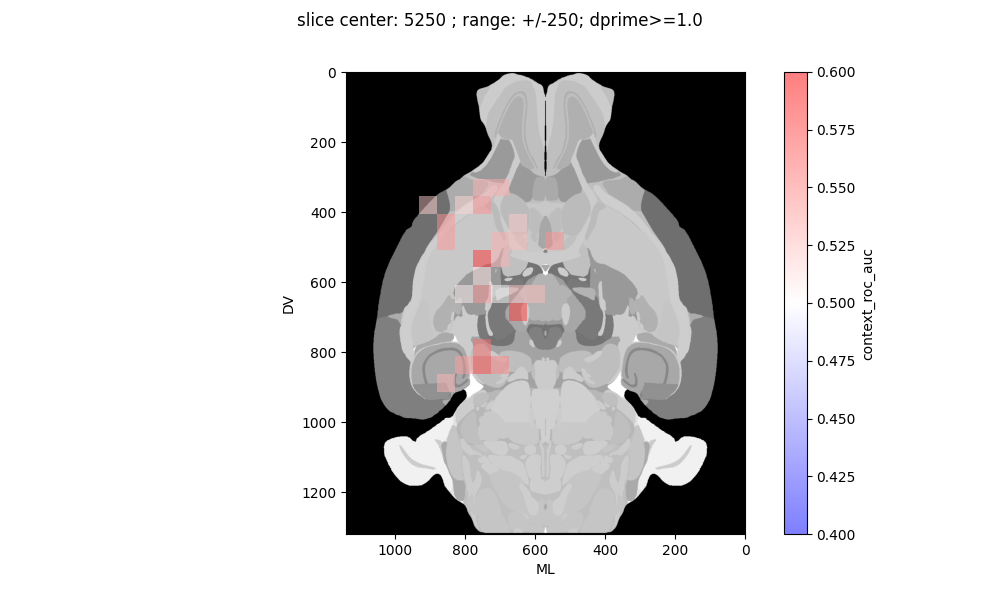

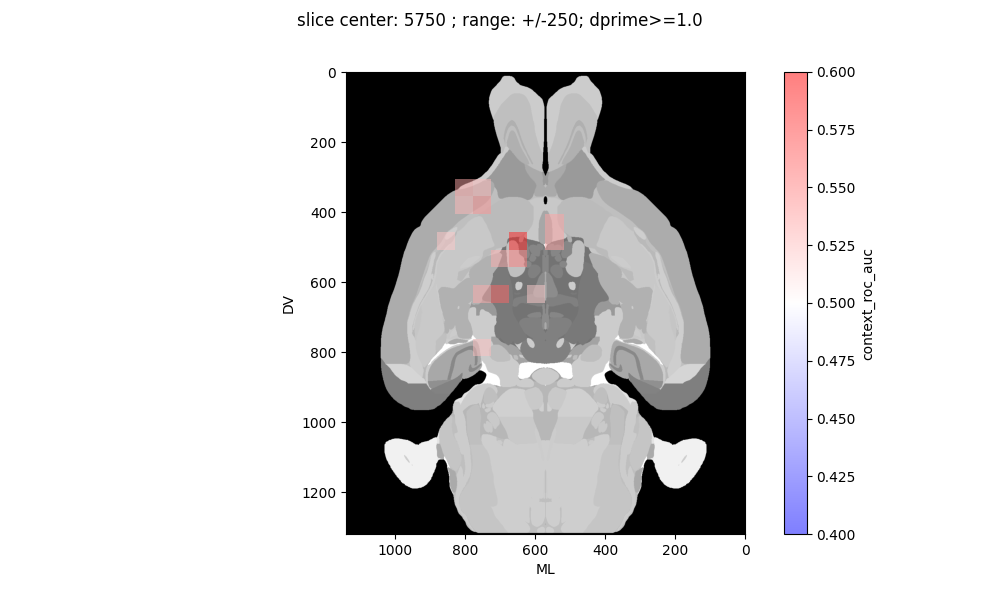

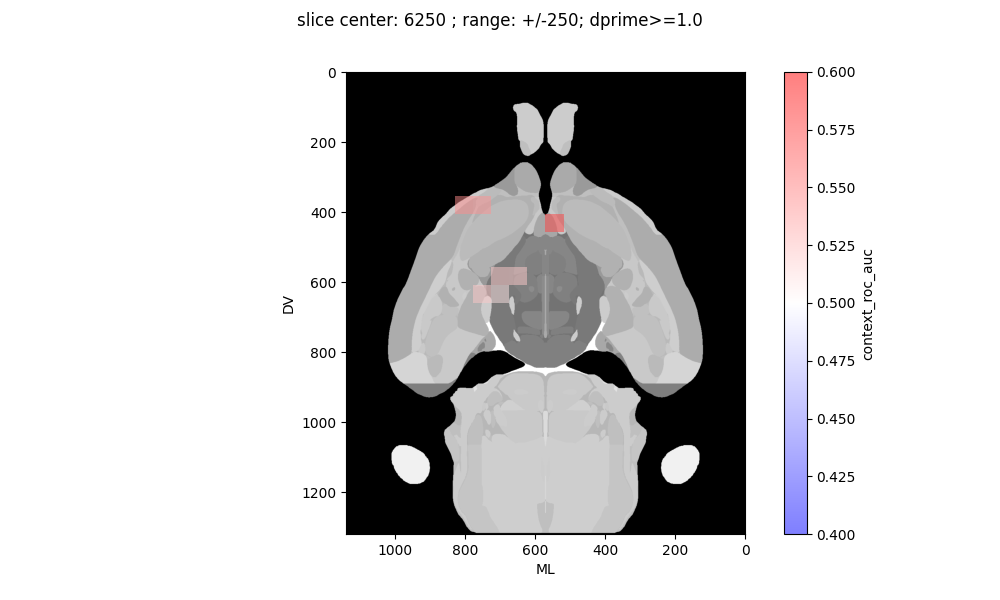

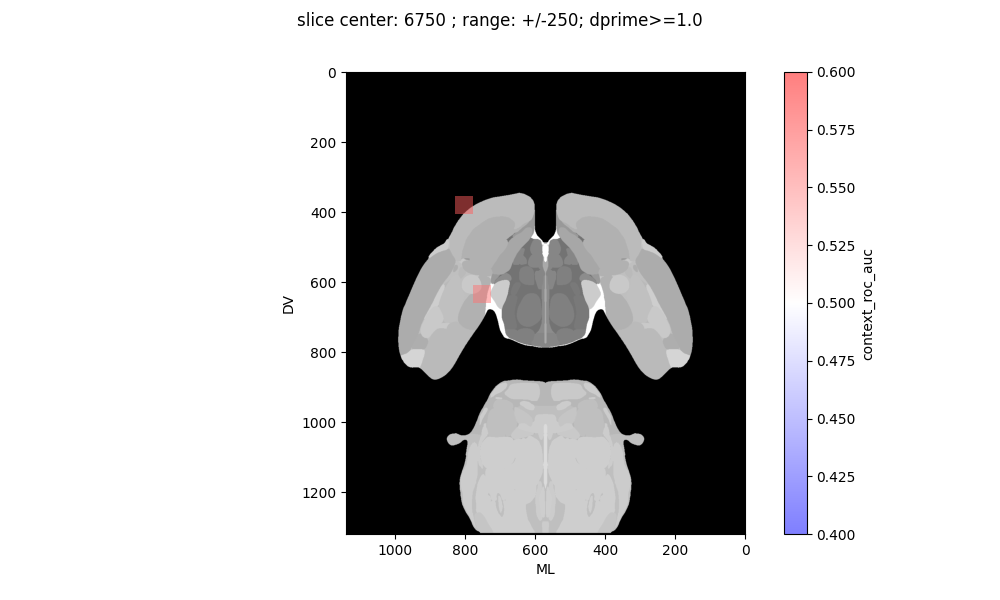

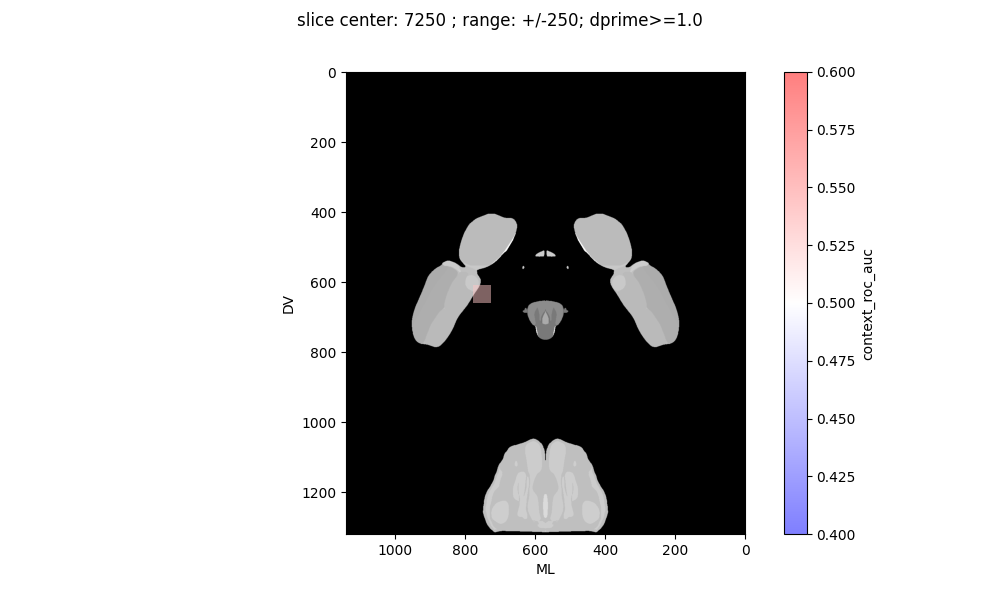

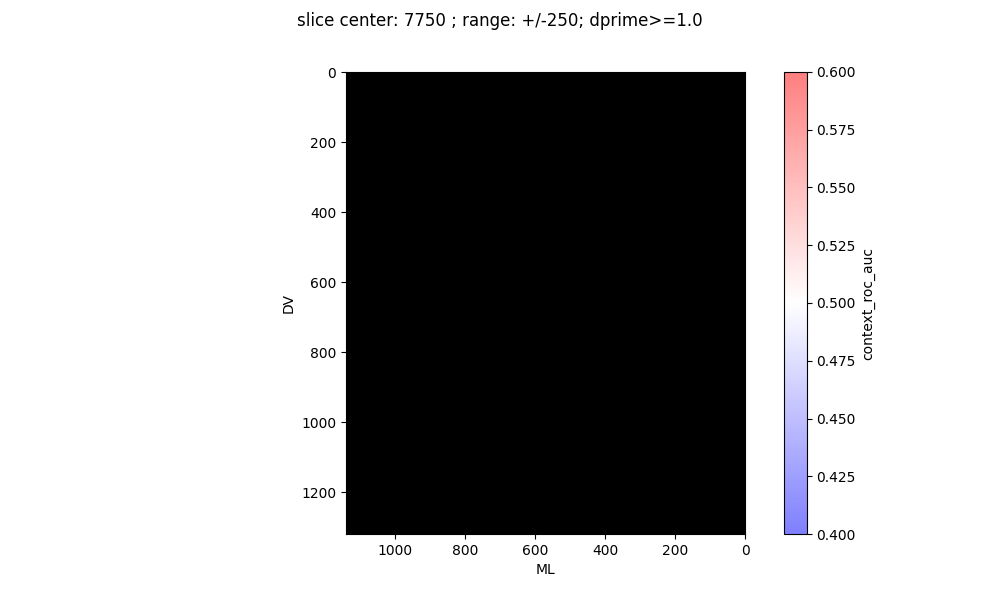

In [23]:
#plot histogram on successive horizontal slices

# plot slices
dprime_thresh=1.0

binsize=50

slice_size=500
slice_pos_array=np.arange(slice_size/2,8000+slice_size/2,slice_size)
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-05-23-single_unit_topography"

plot_variable='context_roc_auc'
# plot_variable='sound1_roc_auc'
# plot_variable='vis1_roc_auc'
# plot_variable='lick_roc_auc'


for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(1, slice_pos)
    results= adj_pvals.query('ccf_dv >= @slice_pos-@slice_size/2 and ccf_dv < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    ax.imshow(gray_image,extent=[1140,0,1320,0],cmap='gray') 

    xsize=annotation.shape[2]
    ysize=annotation.shape[0]

    xinput=results['ccf_ml'].to_numpy(dtype=float)/10
    yinput=results['ccf_ap'].to_numpy(dtype=float)/10

    if 'roc_auc' in plot_variable:
        plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
    else:
        plot_data=results[plot_variable].to_numpy(dtype=float)

    statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='bwr',alpha=0.5,vmin=0.4,vmax=0.6)

    ax.set_xlabel('ML')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=values,label=plot_variable)
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    # filesavepath=os.path.join(savepath,plot_variable+'_horizontal_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)


## metrics on CCF slices - sagittal

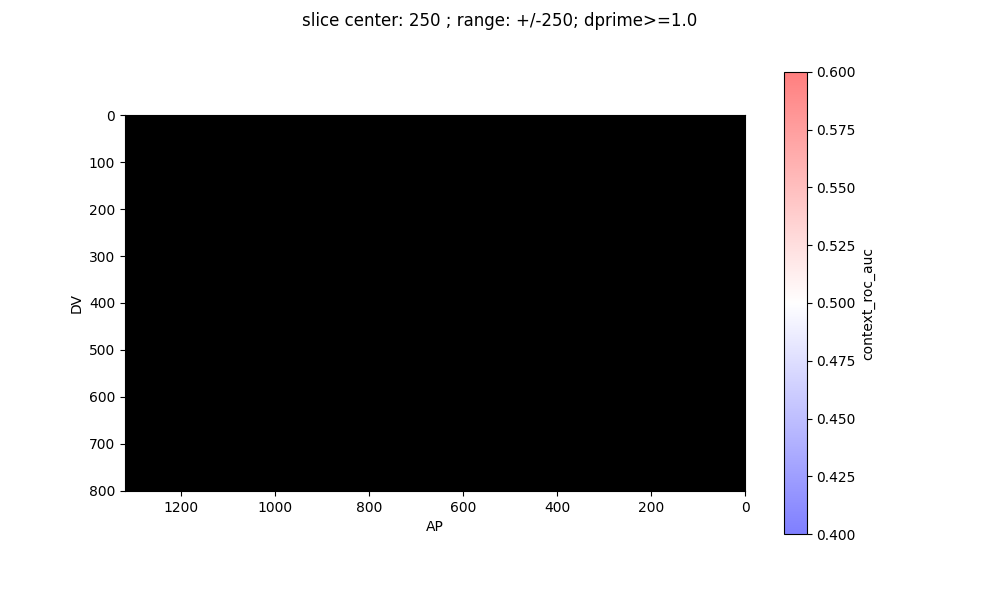

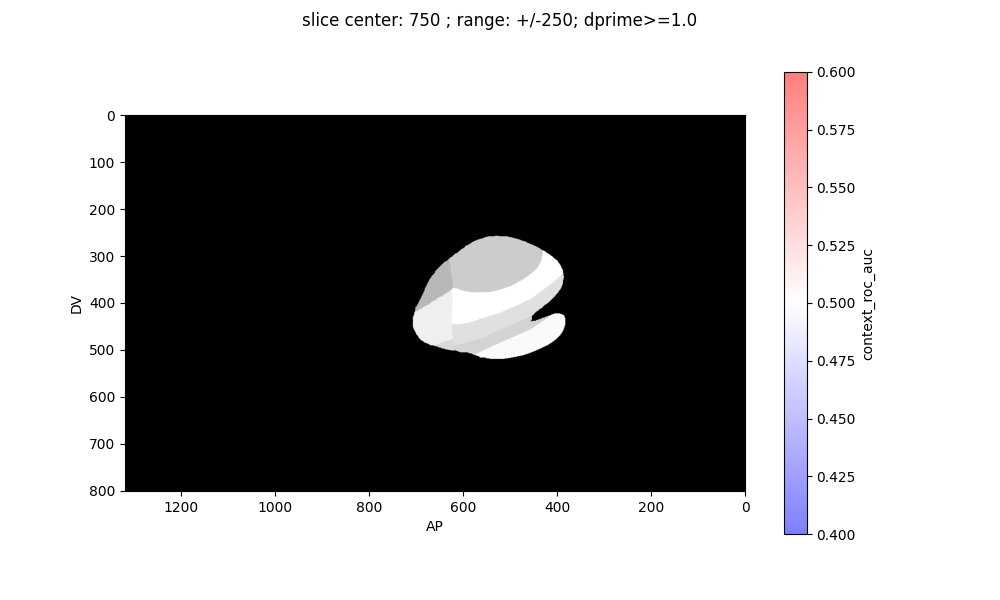

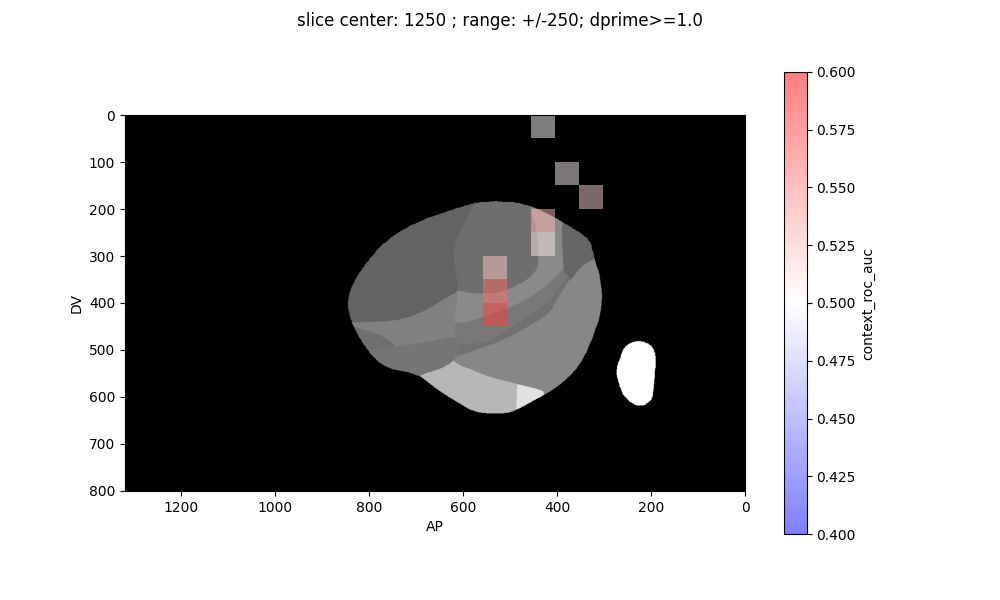

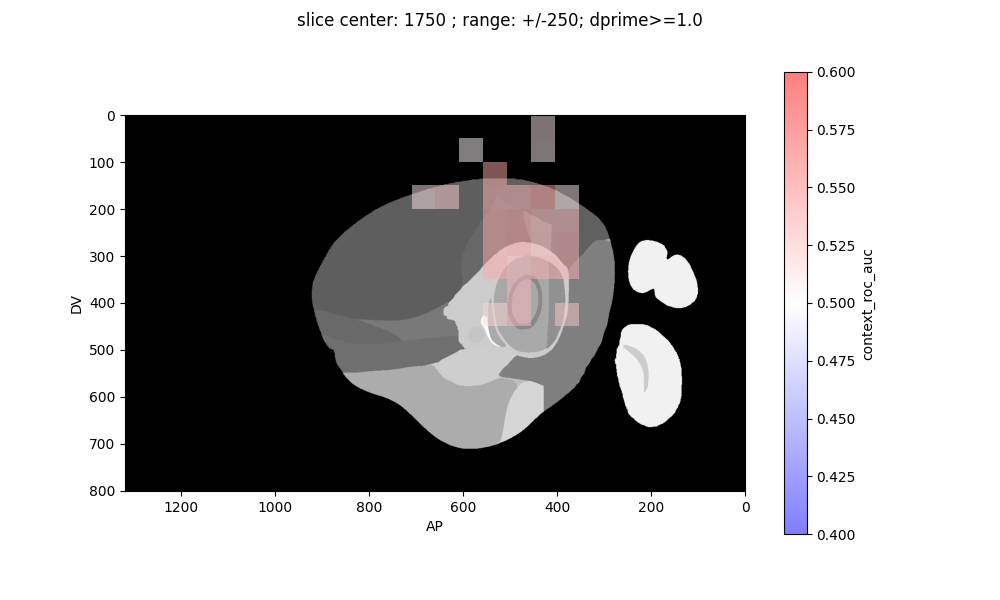

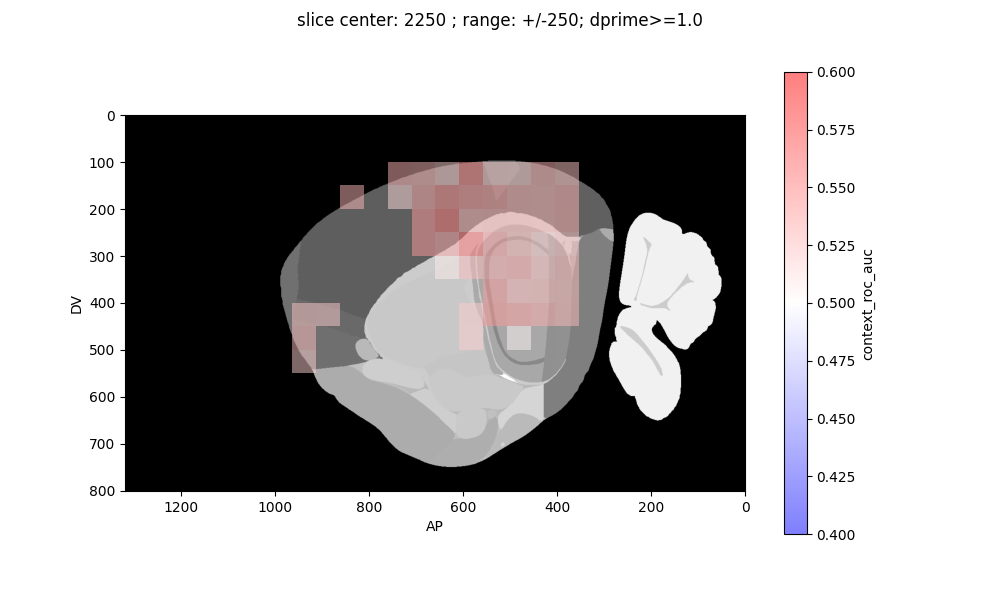

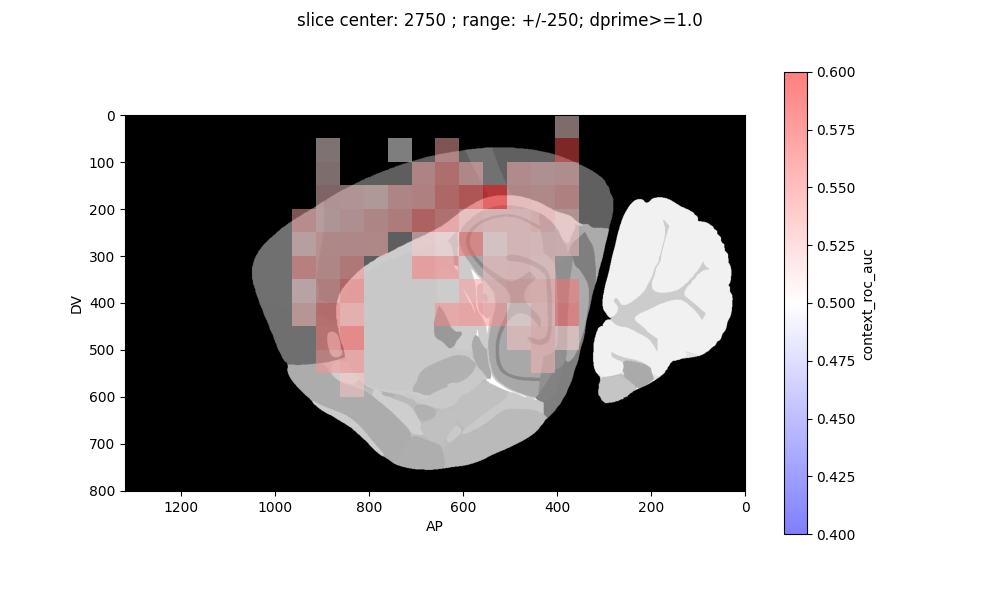

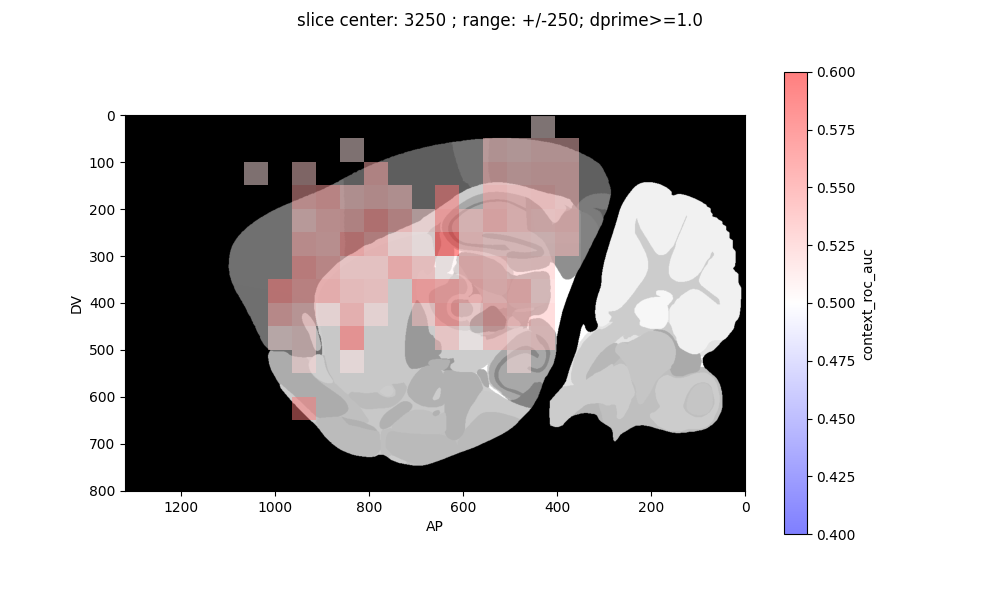

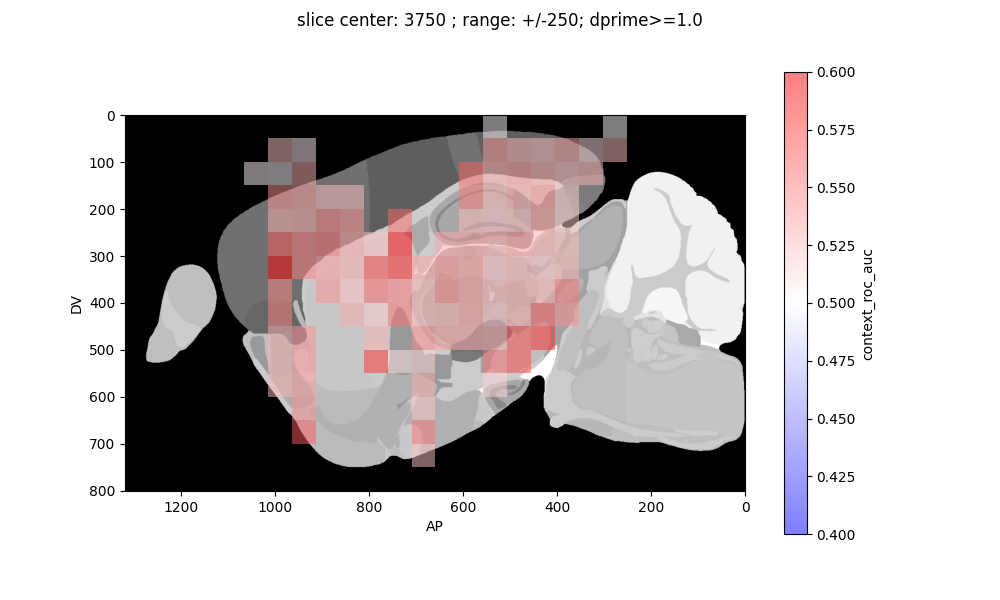

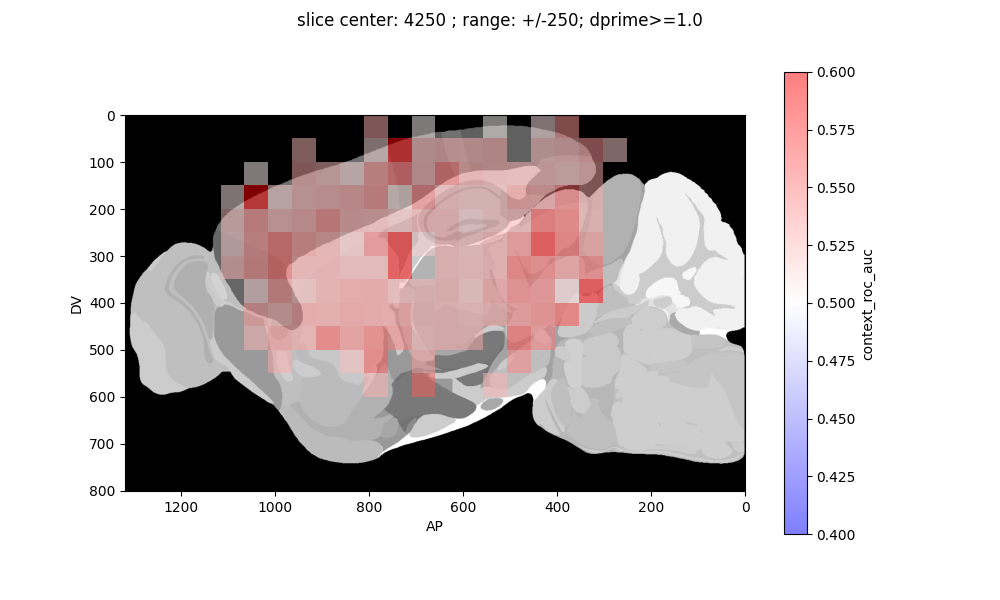

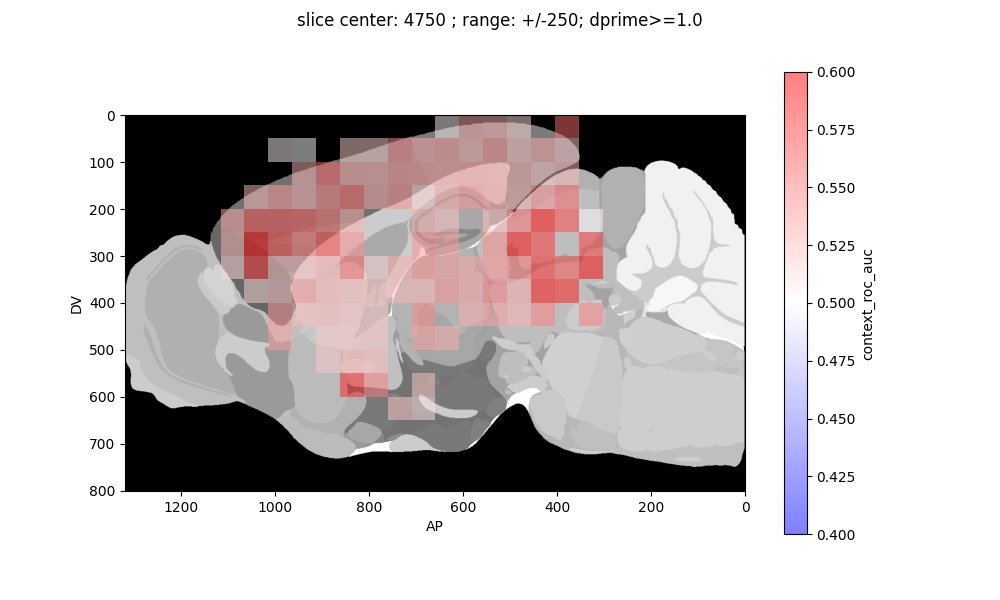

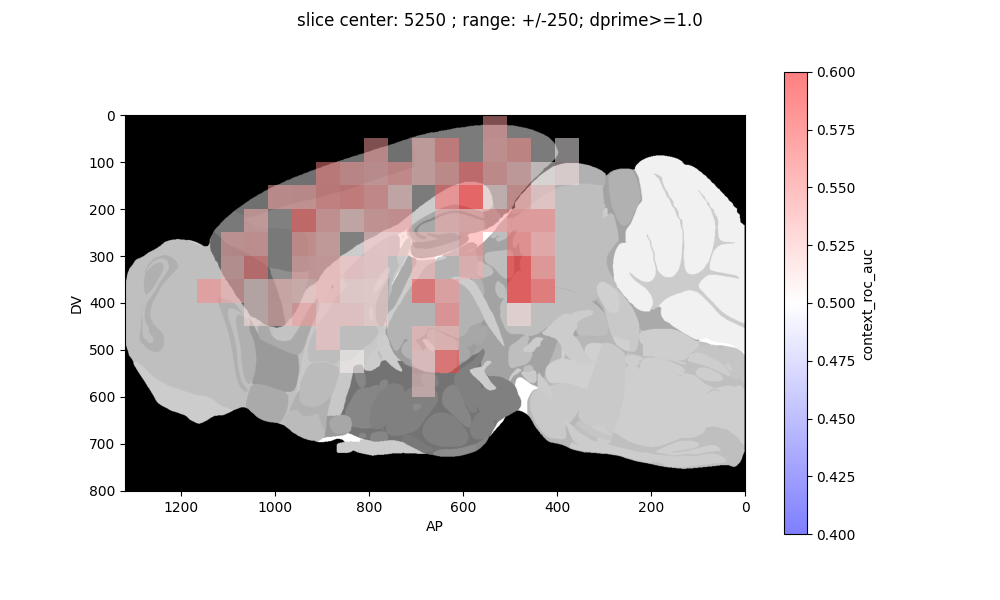

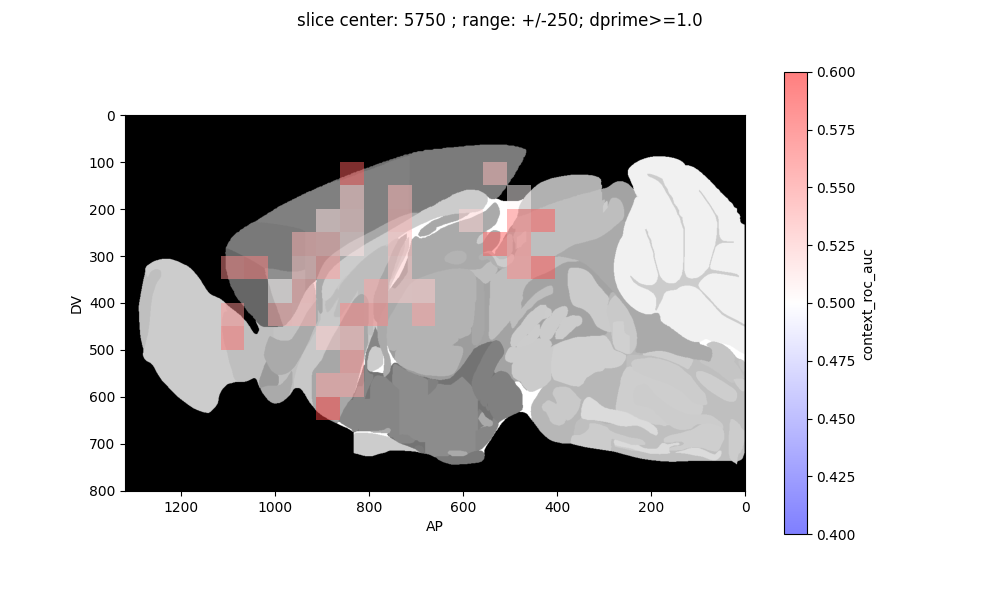

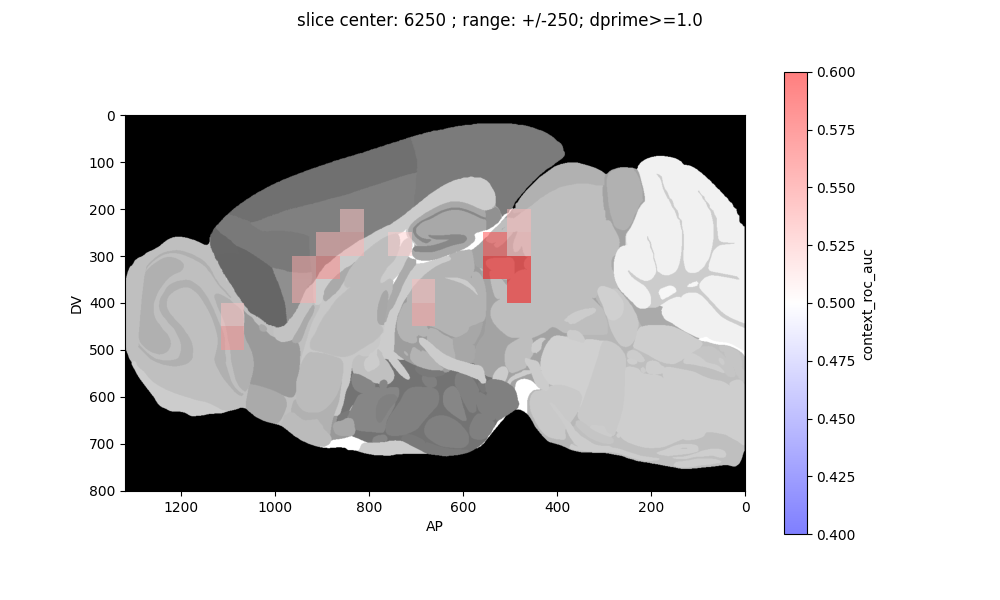

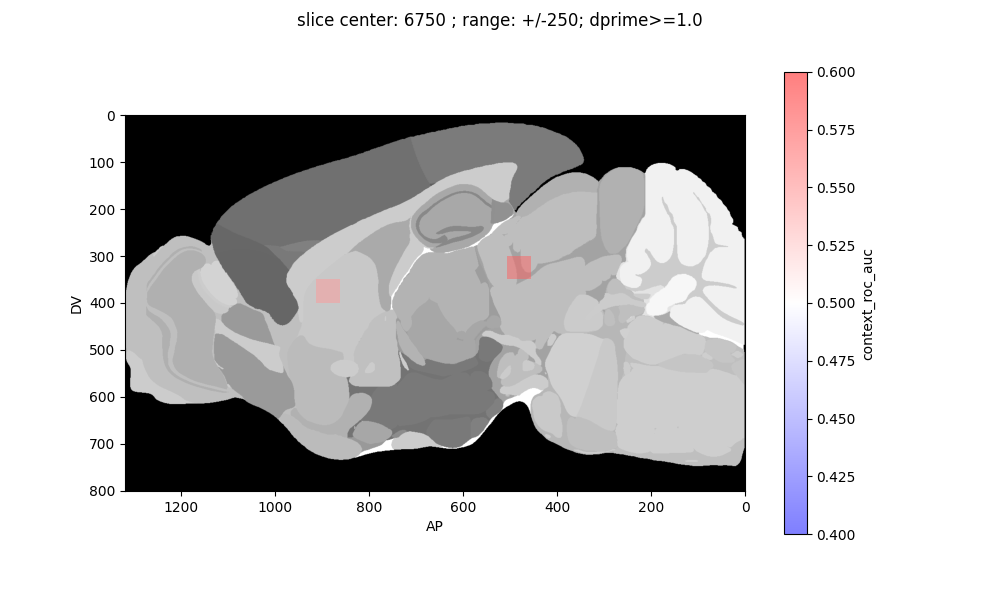

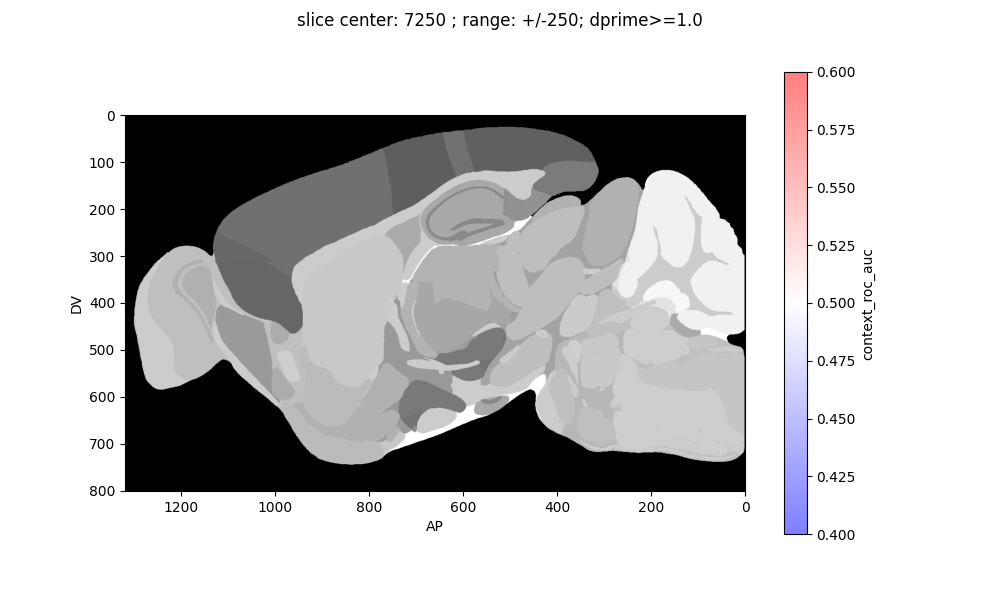

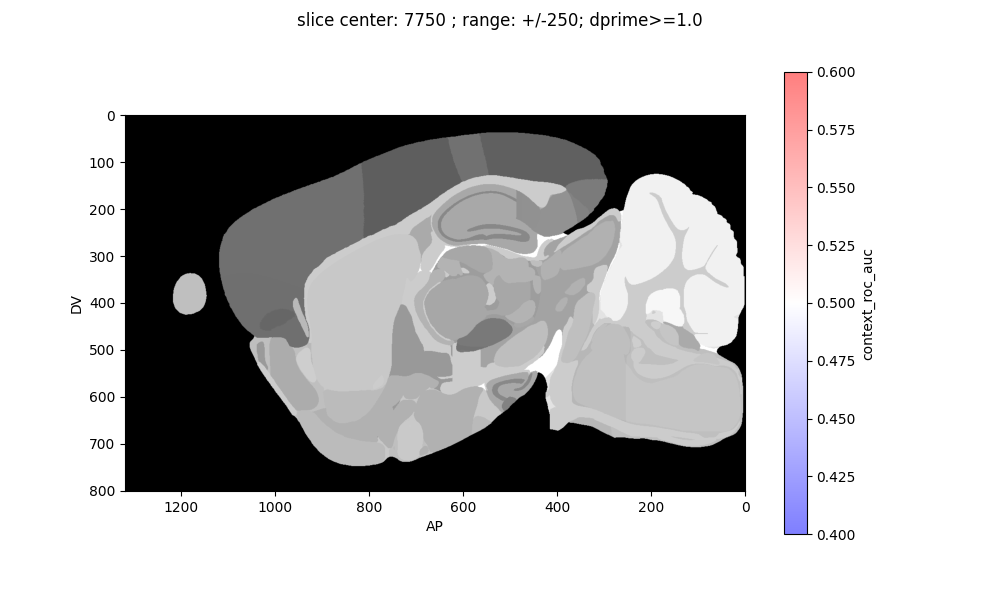

In [30]:
#plot histogram on successive horizontal slices

# plot slices
dprime_thresh=1.0

binsize=50

slice_size=500
slice_pos_array=np.arange(slice_size/2,8000+slice_size/2,slice_size)
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-05-23-single_unit_topography"

plot_variable='context_roc_auc'
# plot_variable='sound1_roc_auc'
# plot_variable='vis1_roc_auc'
# plot_variable='lick_roc_auc'

for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(2, slice_pos)
    results= adj_pvals.query('ccf_ml >= @slice_pos-@slice_size/2 and ccf_ml < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    ax.imshow(gray_image.T,extent=[1320,0,800,0],cmap='gray') 

    xsize=annotation.shape[0]
    ysize=annotation.shape[1]

    xinput=results['ccf_ap'].to_numpy(dtype=float)/10
    yinput=results['ccf_dv'].to_numpy(dtype=float)/10

    if 'roc_auc' in plot_variable:
        plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
    else:
        plot_data=results[plot_variable].to_numpy(dtype=float)

    statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='bwr',alpha=0.5,vmin=0.4,vmax=0.6)

    ax.set_xlabel('AP')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=values,label=plot_variable)
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    # filesavepath=os.path.join(savepath,plot_variable+'_sagittal_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)
